# Task 1: Acquire, Preproess and Analyze Data


## Import libraries and data



In [ ]:
import pandas as pd
pd.set_option('display.max_rows', 700)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GroupShuffleSplit

In [ ]:
searchTrendData = pd.read_csv("https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv")
hospitalizationData = pd.read_csv("https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv")

/opt/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean the Dataframe

There are columns in the dataframe where the whole column contains nothing but NaN, 
so these columns need to be dropped. 

Then there are columns that contains a large
amount of NaNs. These should be dropped too once the amount of NaN reaches a certain
threshold. Several experimentation were performed to decide the best value for this
threshold. The higher the threshold, the more columns dropped. 

In [ ]:
## drop all NaN columns for searchTrendData
searchTrendData = searchTrendData.dropna('columns', 'all')
## drop column if it doesn't have at least 60% of non-NaN values
searchTrendData = searchTrendData.dropna(axis = "columns", thresh = (int) (searchTrendData.shape[0] * 0.6))

## drop all data that is not from the US
hospitalizationData = hospitalizationData[hospitalizationData['open_covid_region_code'].str.contains('US-')]
## drop all NaN columns for hospitalizationData
hospitalizationData = hospitalizationData.dropna('columns', 'all')
## drop the column if it doesn't have at least 30% of non-Nan values 
hospitalizationData = hospitalizationData.dropna(axis = "columns", thresh = (int) (hospitalizationData.shape[0] * 0.3))

Merge two dataset

In [ ]:
## debug cell, delete when assignment is finished
searchTrendData
len(searchTrendData[searchTrendData['open_covid_region_code'] == 'US-WY'])

40

In [ ]:
# searchTrendData.iloc[7:10, :]

In [ ]:
## debug cell, delete when assignment is finished
hospitalizationData['date'] = pd.to_datetime(hospitalizationData['date'])
hospitalizationData['date'] = hospitalizationData['date'] - pd.to_timedelta(hospitalizationData['date'].dt.weekday, unit='D')
## Feiyang Li --> Once you changed hospitalization data to weekly resolution, there are many duplicates. Let's drop them
## and see how it works
## 
hospitalizationData = hospitalizationData.drop_duplicates();
hospitalizationData

,open_covid_region_code,region_name,date,hospitalized_cumulative,hospitalized_new
83900,US-WY,Wyoming,2020-03-02,0.0,0.0
83902,US-WY,Wyoming,2020-03-09,0.0,0.0
83909,US-WY,Wyoming,2020-03-16,0.0,0.0
83916,US-WY,Wyoming,2020-03-23,0.0,0.0
83920,US-WY,Wyoming,2020-03-23,11.0,11.0
...,...,...,...,...,...
96686,US-AK,Alaska,2020-09-14,0.0,0.0
96693,US-AK,Alaska,2020-09-21,0.0,0.0
96700,US-AK,Alaska,2020-09-28,0.0,0.0
96707,US-AK,Alaska,2020-10-05,0.0,0.0


In [ ]:
hospitalizationData
# len(hospitalizationData[hospitalizationData['open_covid_region_code'] == 'US-WY'])

,open_covid_region_code,region_name,date,hospitalized_cumulative,hospitalized_new
83900,US-WY,Wyoming,2020-03-02,0.0,0.0
83902,US-WY,Wyoming,2020-03-09,0.0,0.0
83909,US-WY,Wyoming,2020-03-16,0.0,0.0
83916,US-WY,Wyoming,2020-03-23,0.0,0.0
83920,US-WY,Wyoming,2020-03-23,11.0,11.0
...,...,...,...,...,...
96686,US-AK,Alaska,2020-09-14,0.0,0.0
96693,US-AK,Alaska,2020-09-21,0.0,0.0
96700,US-AK,Alaska,2020-09-28,0.0,0.0
96707,US-AK,Alaska,2020-10-05,0.0,0.0


In [ ]:
## change dates to weekly represented dates
hospitalizationData['date'] = pd.to_datetime(hospitalizationData['date'])
hospitalizationData['date'] = hospitalizationData['date'] - pd.to_timedelta(hospitalizationData['date'].dt.weekday, unit='D')

## drop the hospitalized_culumative column since it doesn't make since to merge them into a weekly entry
hospitalizationData = hospitalizationData.drop('hospitalized_cumulative', axis = 1)

## combine all data with the same region code, and the same date
## find all unique dates and regions
region_codes = hospitalizationData['open_covid_region_code'].unique()

result_df = pd.DataFrame()
## group all rows with the same region code
for code in region_codes:
    region_rows = hospitalizationData.groupby(['open_covid_region_code']).get_group(code)
    ## group these rows again by dates
    dates = region_rows['date'].unique()
    for date in dates:
        region_data = region_rows.groupby('date').get_group(date)

        ## combine all these entries into one row additively
        result_row = region_data.head(1)
        for r in range(1, region_data.shape[0]):
            for i in range(3, result_row.shape[1]):
                current_column = result_row.columns[i]
                result_row[current_column] += region_data.iloc[r][current_column]
        result_df = result_df.append(result_row)
    print(result_row)

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      open_covid_region_code region_name       date  hospitalized_new
84119                  US-WY     Wyoming 2020-10-12              37.0
      open_covid_region_code    region_name       date  hospitalized_new
84346                  US-WV  West Virginia 2020-10-12               0.0
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/venv/

In [ ]:
result_df.reset_index(inplace = True)
result_df


,index,open_covid_region_code,region_name,date,hospitalized_new
0,83900,US-WY,Wyoming,2020-03-02,0.0
1,83902,US-WY,Wyoming,2020-03-09,0.0
2,83909,US-WY,Wyoming,2020-03-16,0.0
3,83916,US-WY,Wyoming,2020-03-23,15.0
4,83923,US-WY,Wyoming,2020-03-30,8.0
...,...,...,...,...,...
1852,96686,US-AK,Alaska,2020-09-14,0.0
1853,96693,US-AK,Alaska,2020-09-21,0.0
1854,96700,US-AK,Alaska,2020-09-28,0.0
1855,96707,US-AK,Alaska,2020-10-05,0.0


In [ ]:
## this should merge two dataframe without duplicates
searchTrendData['date'] = pd.to_datetime(searchTrendData['date'])
result_df['date'] = pd.to_datetime(result_df['date'])
mergedData = searchTrendData.merge(result_df, on = ['open_covid_region_code', 'date'], how = 'left');
mergedData
#do we want to do outer merge or do we want to do inner join based on date and open_covid_region_code

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,...,symptom:Rectal pain,symptom:Rumination,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,index,region_name,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-01-06,NaN,NaN,NaN,8.33,...,NaN,13.68,NaN,10.31,NaN,9.91,NaN,NaN,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,2020-01-13,NaN,NaN,NaN,8.22,...,8.41,NaN,NaN,15.49,7.65,8.41,NaN,NaN,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,2020-01-20,NaN,NaN,NaN,8.28,...,7.91,13.98,NaN,14.90,7.54,16.19,NaN,NaN,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,2020-01-27,7.47,7.65,NaN,10.39,...,9.66,10.20,NaN,15.12,NaN,NaN,NaN,NaN,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,2020-02-03,8.06,12.56,7.50,10.31,...,NaN,10.50,NaN,11.43,NaN,10.68,10.50,NaN,NaN,NaN
5,US-AK,US,United States,Alaska,US-AK,2020-02-10,NaN,10.88,NaN,11.43,...,13.60,8.89,7.62,12.88,7.44,NaN,7.80,NaN,NaN,NaN
6,US-AK,US,United States,Alaska,US-AK,2020-02-17,NaN,9.16,NaN,9.16,...,8.14,7.29,NaN,12.72,NaN,8.65,8.48,NaN,NaN,NaN
7,US-AK,US,United States,Alaska,US-AK,2020-02-24,10.61,7.29,NaN,8.95,...,10.61,9.94,NaN,9.28,7.13,8.62,11.10,NaN,NaN,NaN
8,US-AK,US,United States,Alaska,US-AK,2020-03-02,NaN,NaN,6.64,NaN,...,8.14,6.98,NaN,12.46,NaN,10.46,14.12,96494.0,Alaska,0.0
9,US-AK,US,United States,Alaska,US-AK,2020-03-09,NaN,7.91,NaN,NaN,...,7.07,8.58,8.08,13.97,NaN,NaN,18.85,96497.0,Alaska,0.0


In [ ]:
# for region in mergedData['open_covid_region_code'].unique():
 #    print(mergedData[mergedData['open_covid_region_code'] == region].shape)



(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)
(40, 24)


# Task 2: Visualize and cluster the data

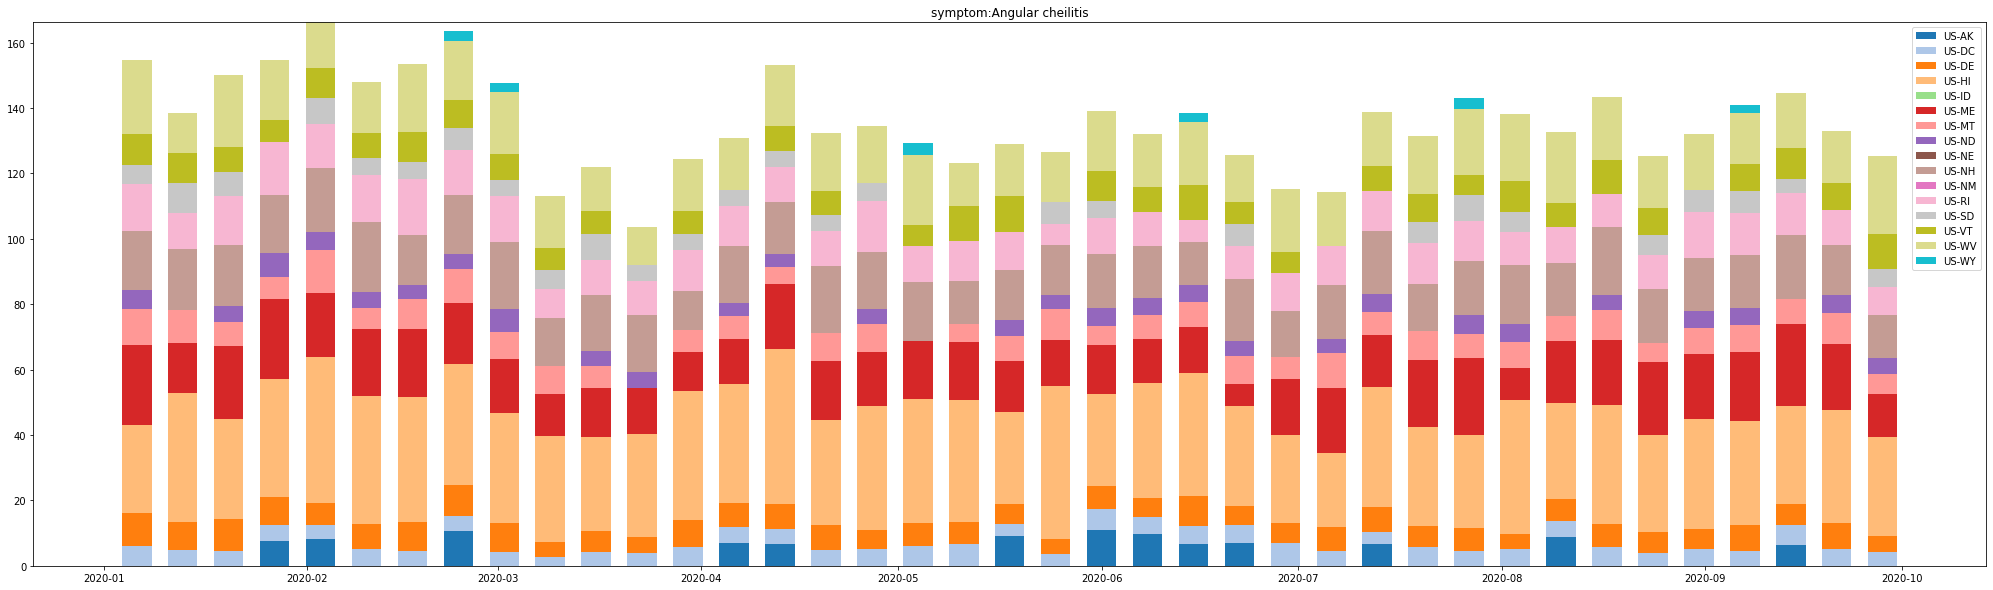

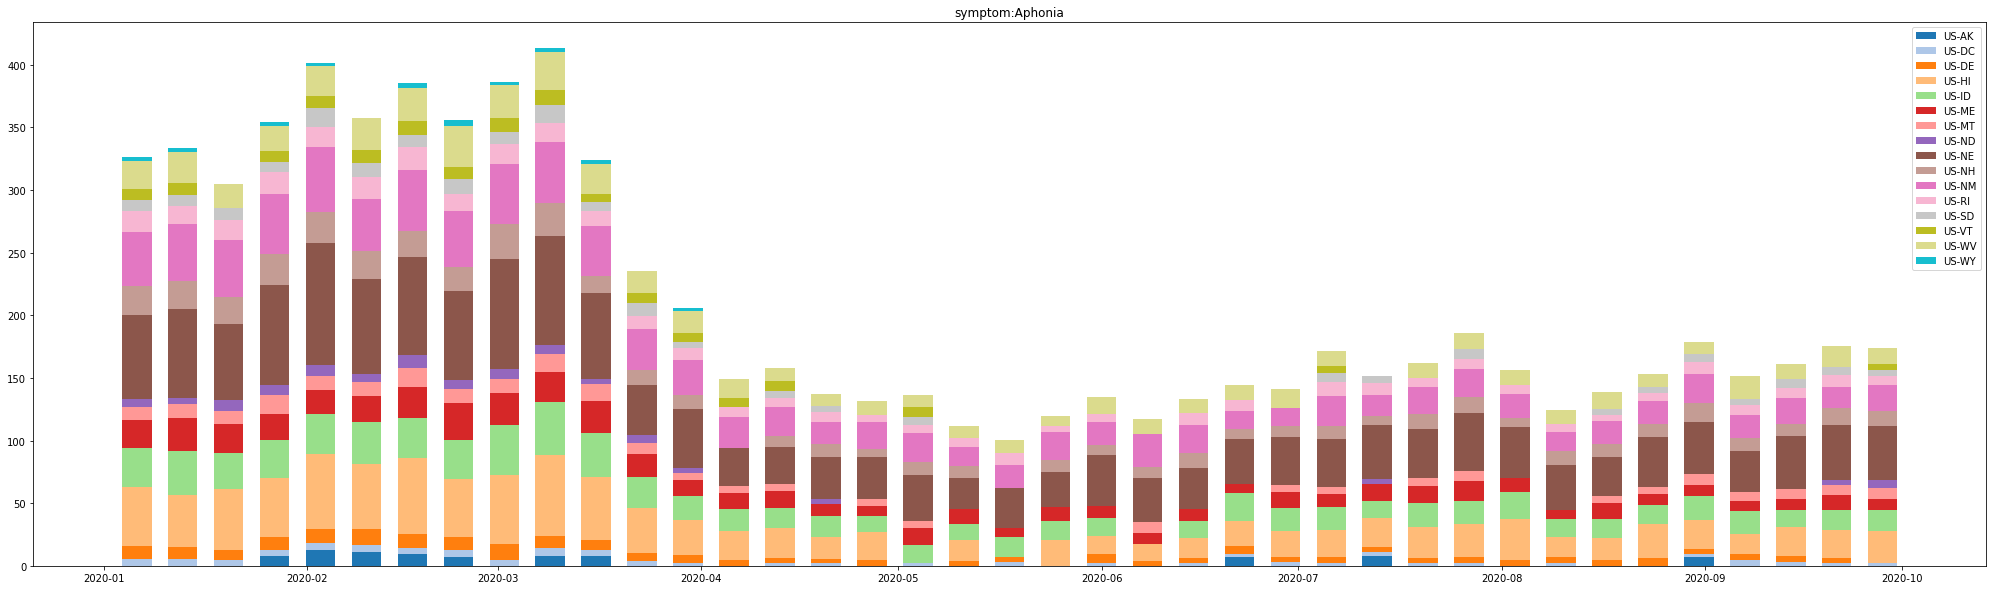

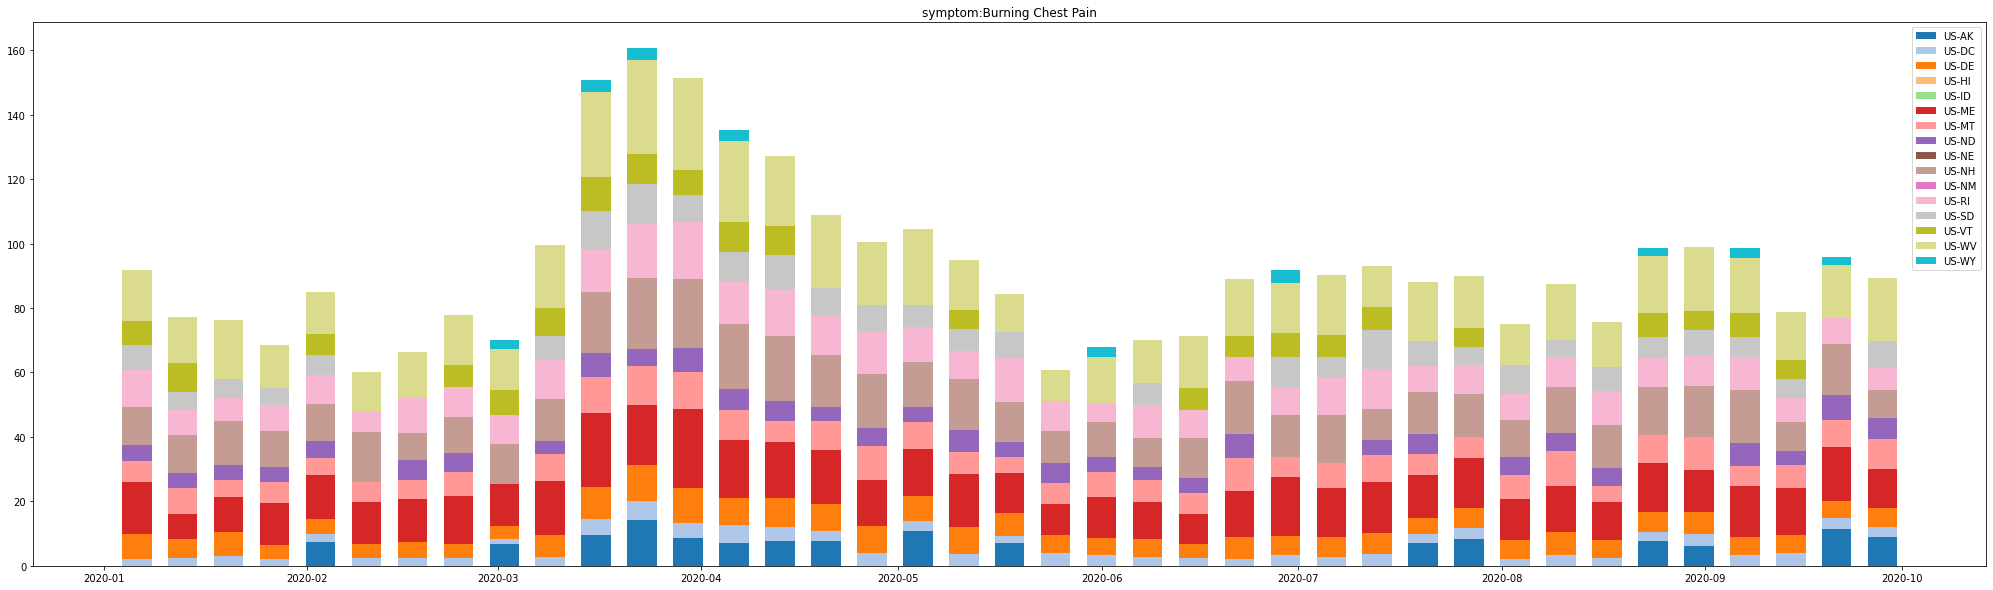

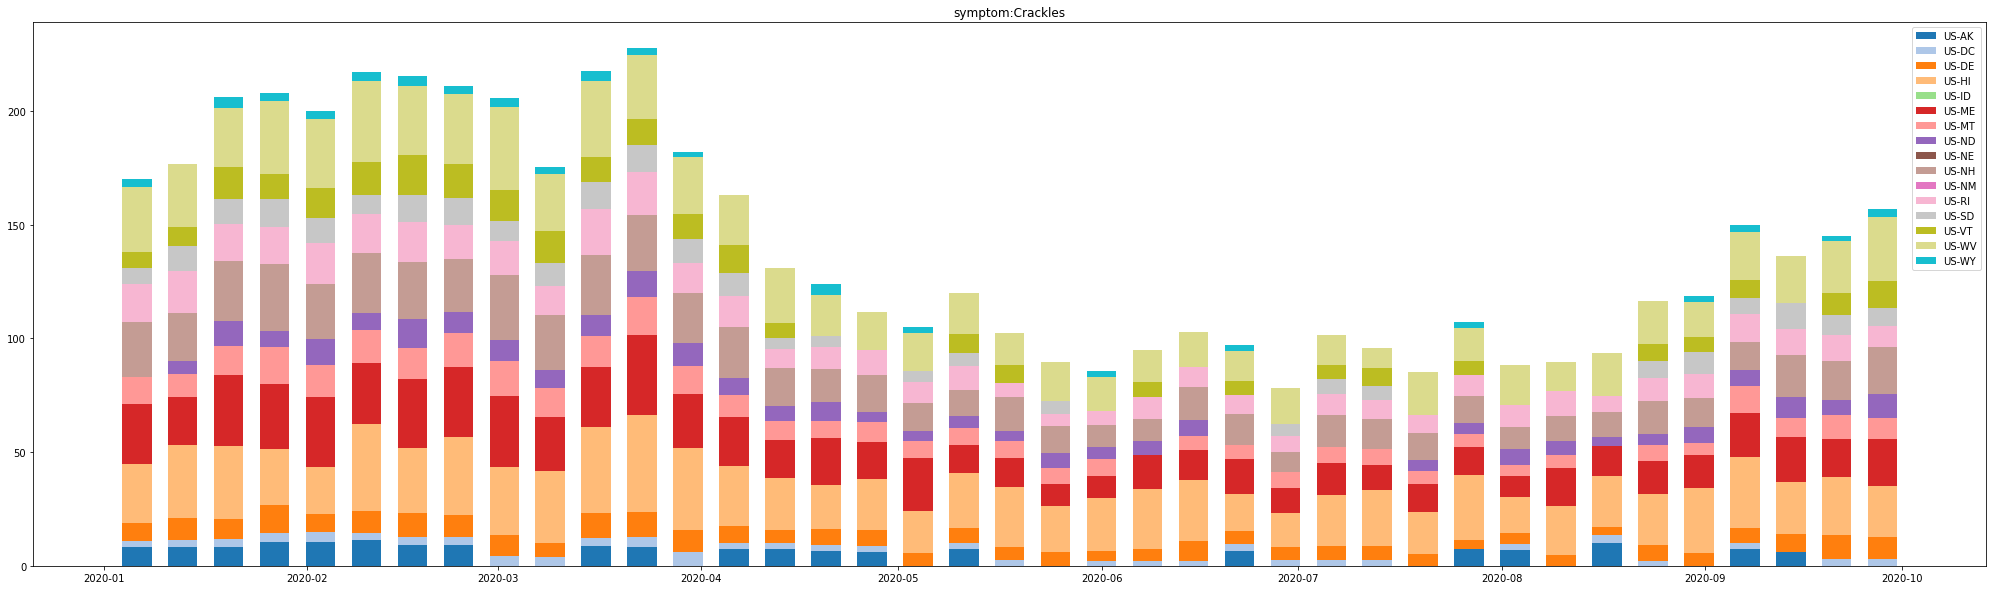

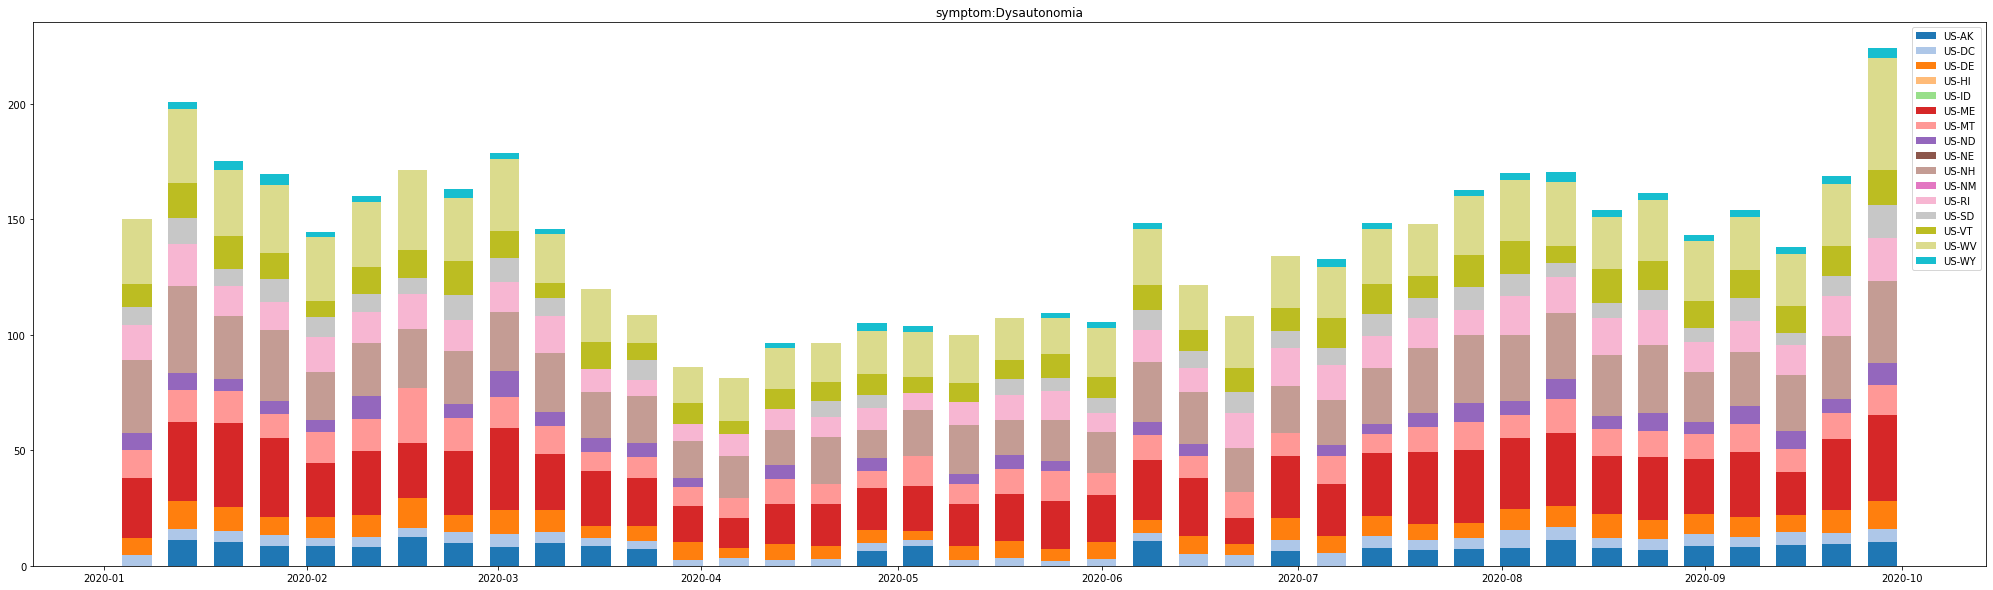

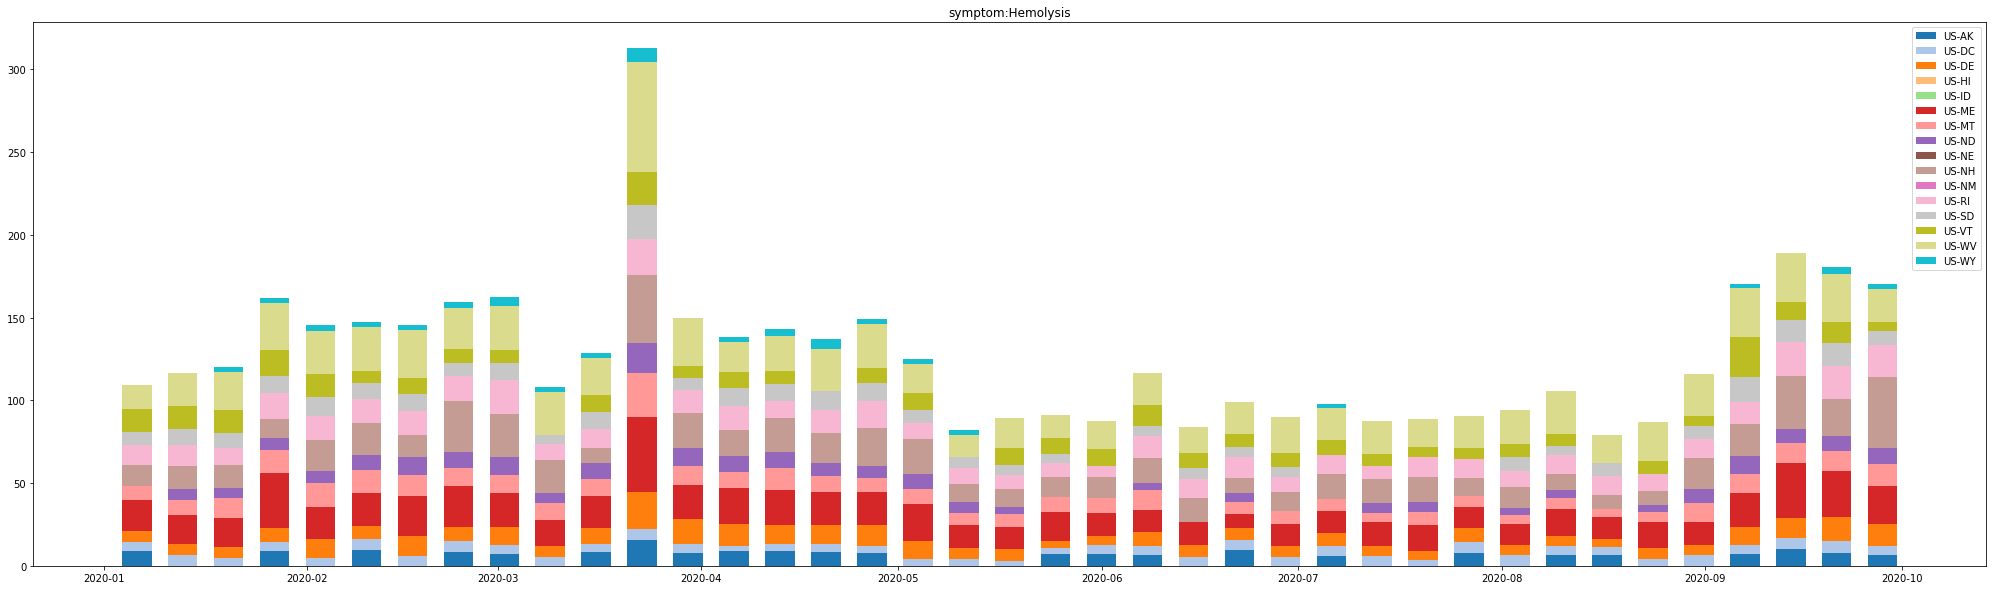

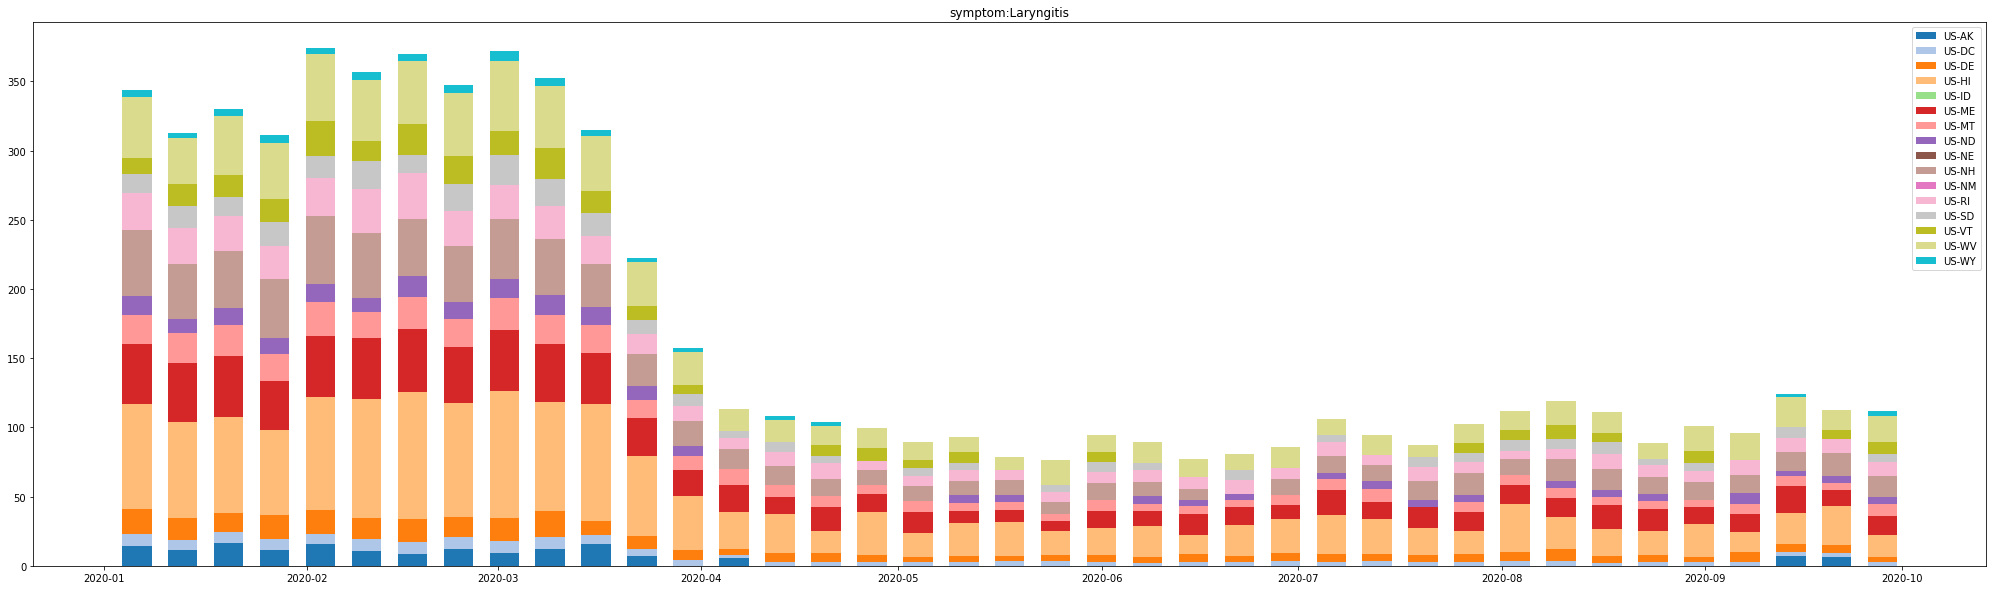

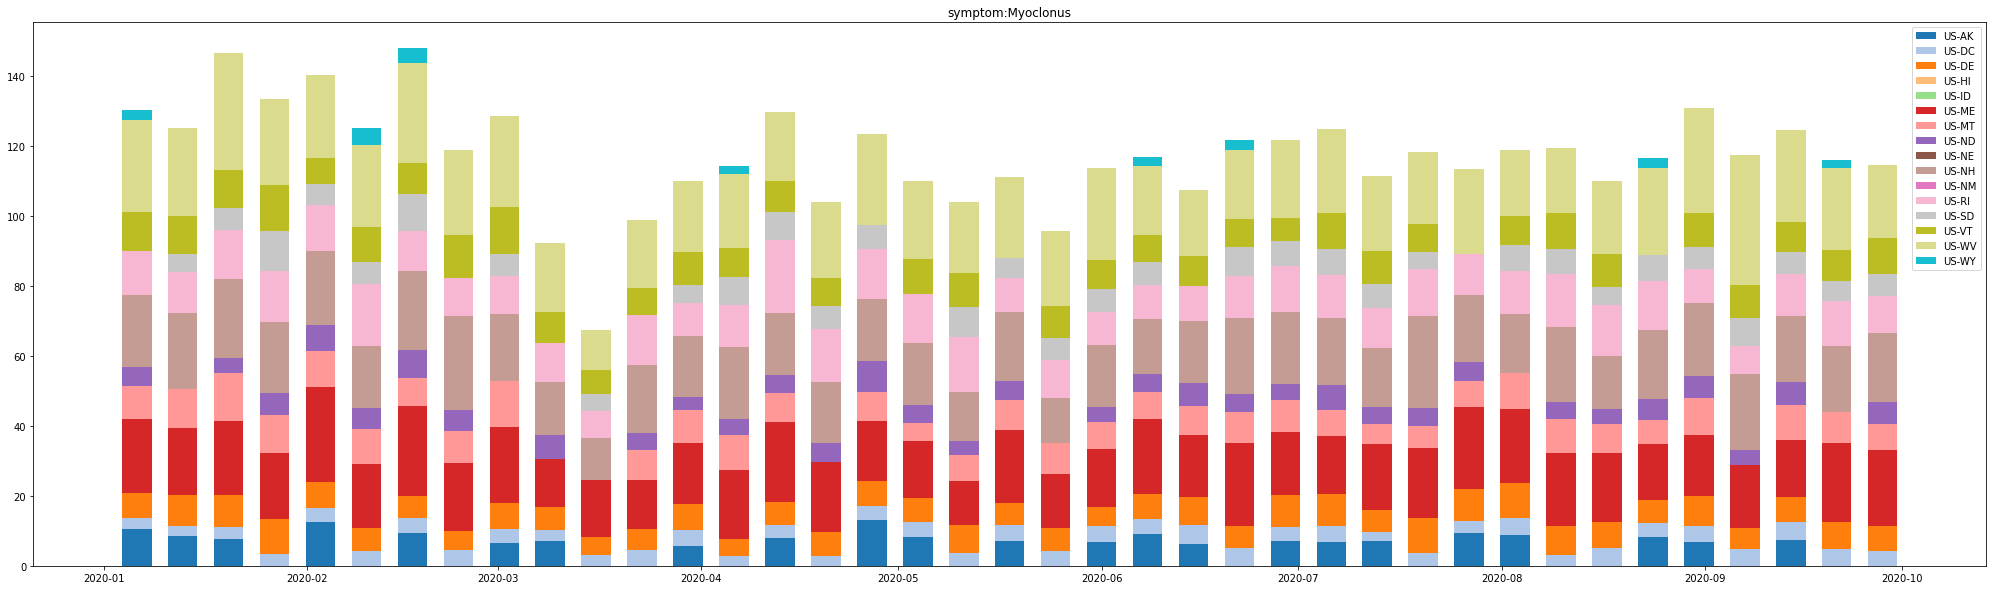

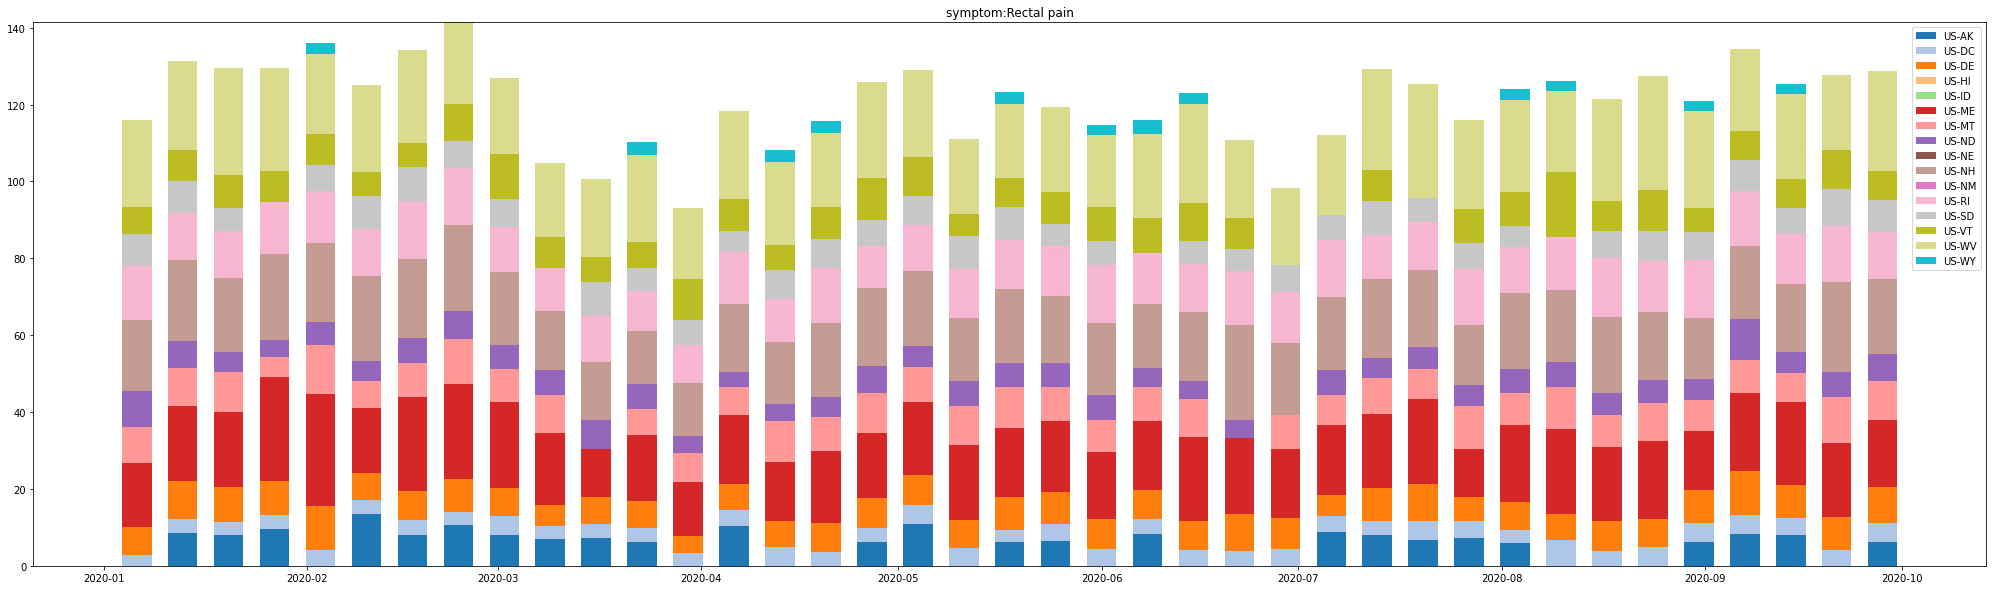

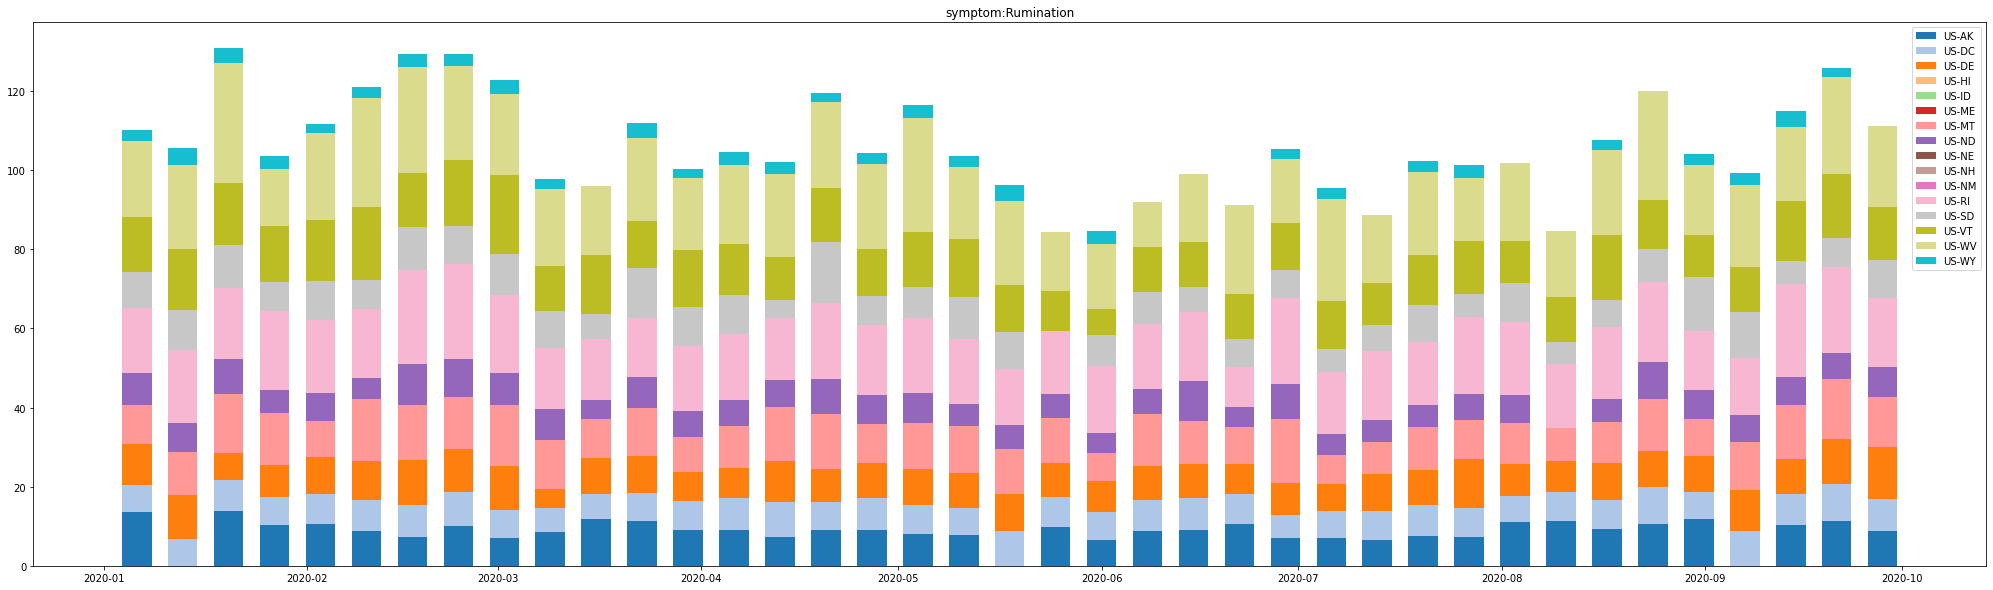

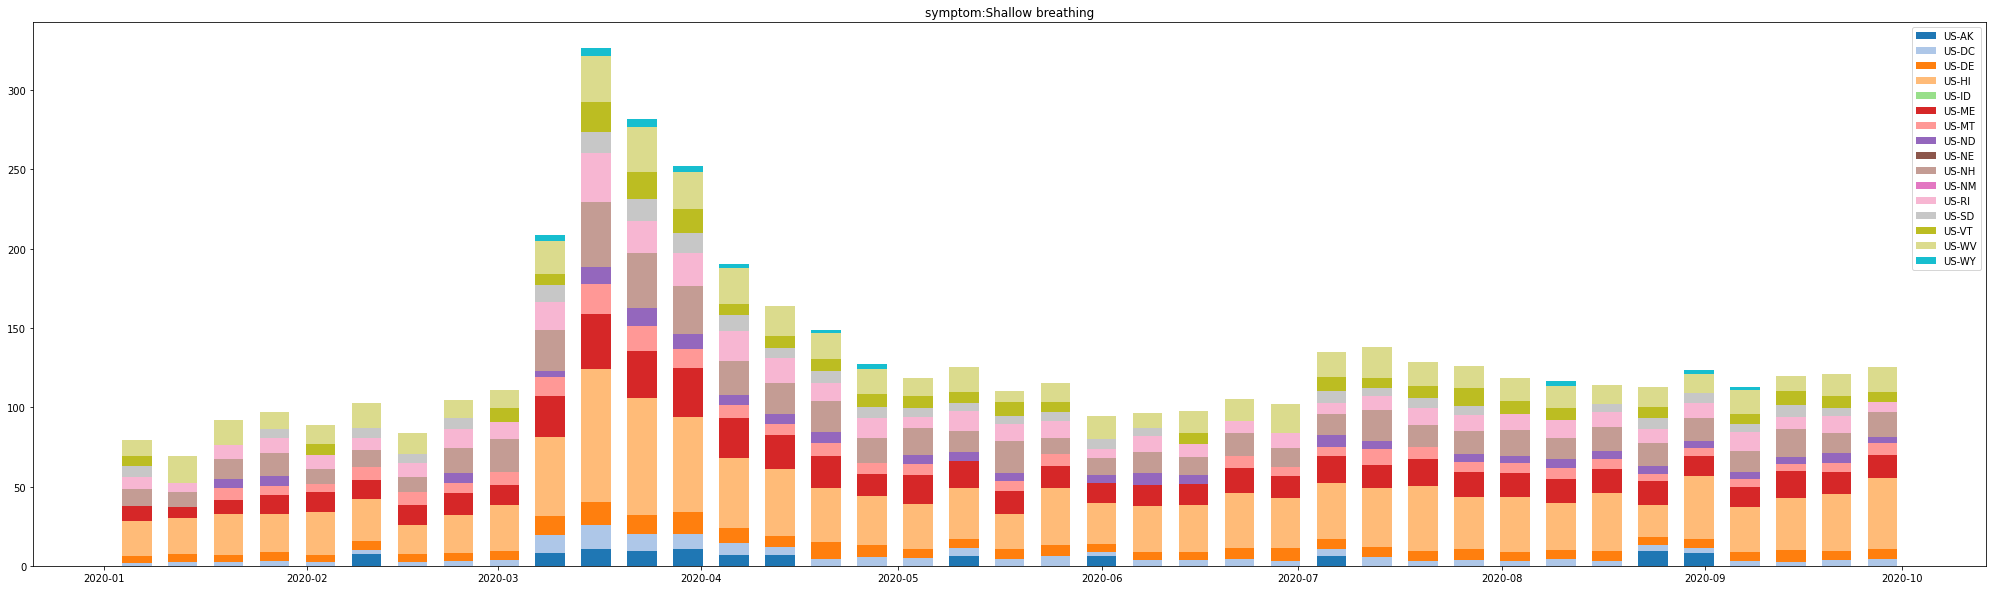

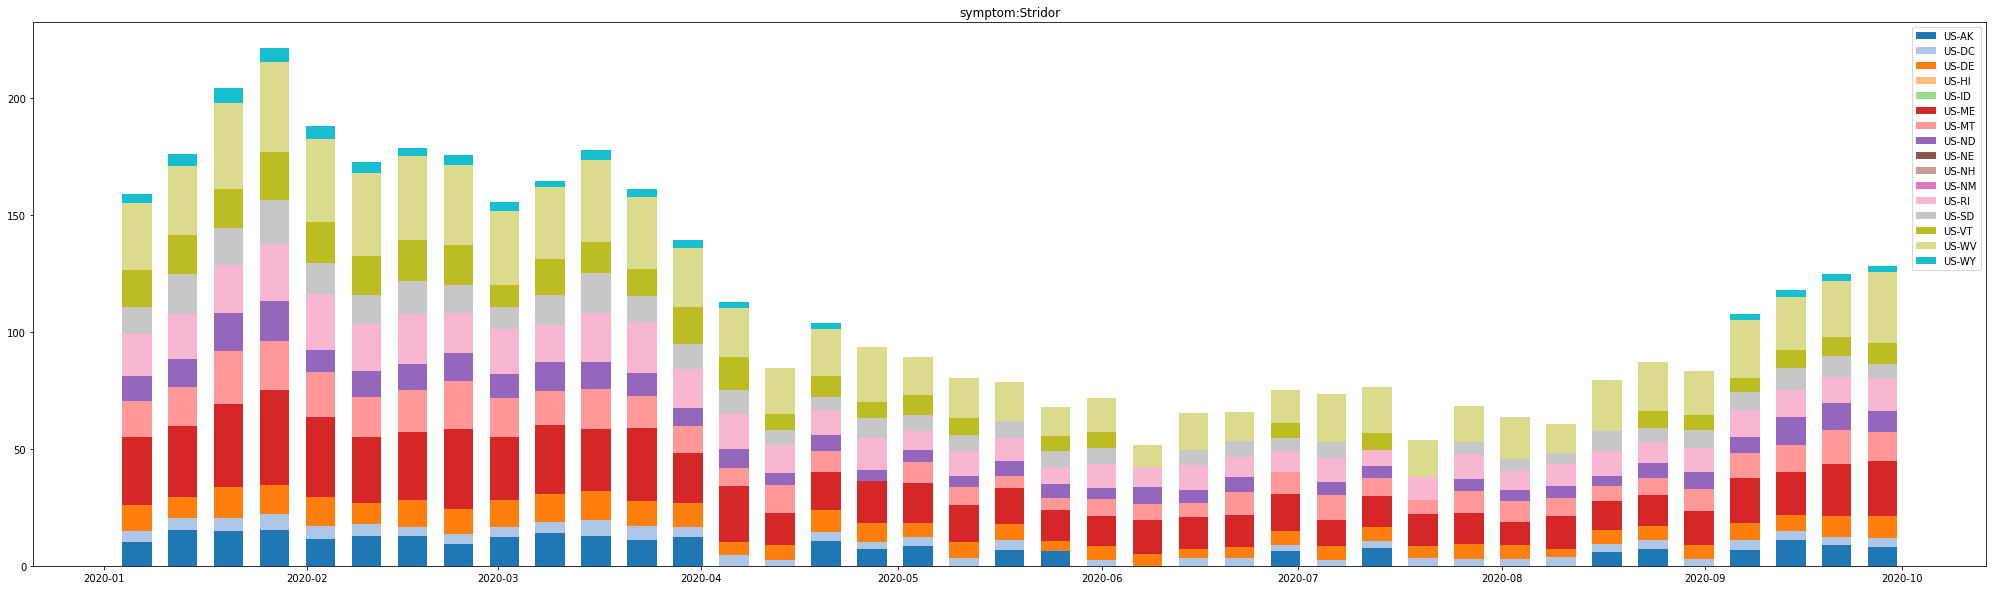

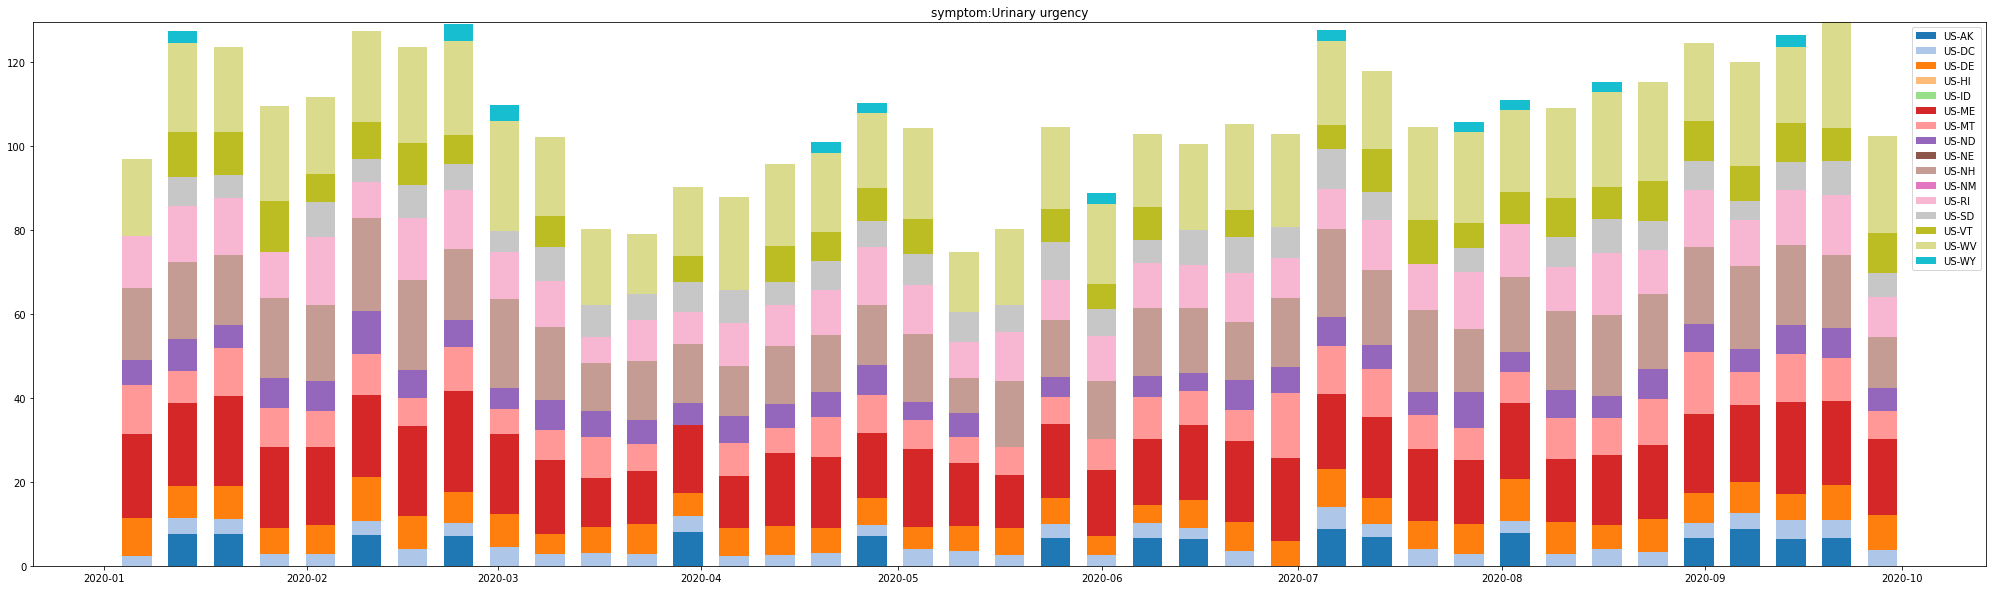

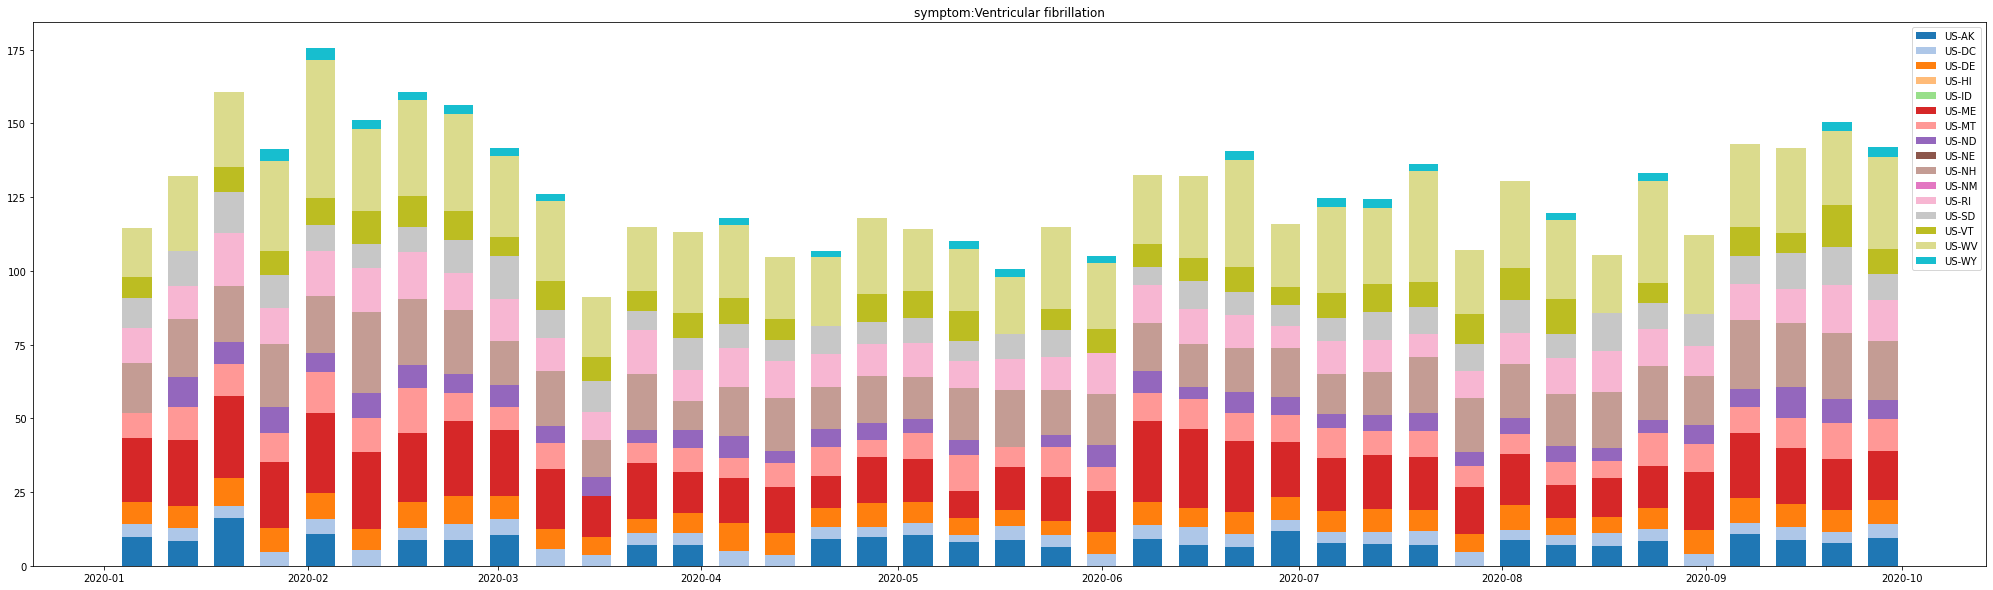

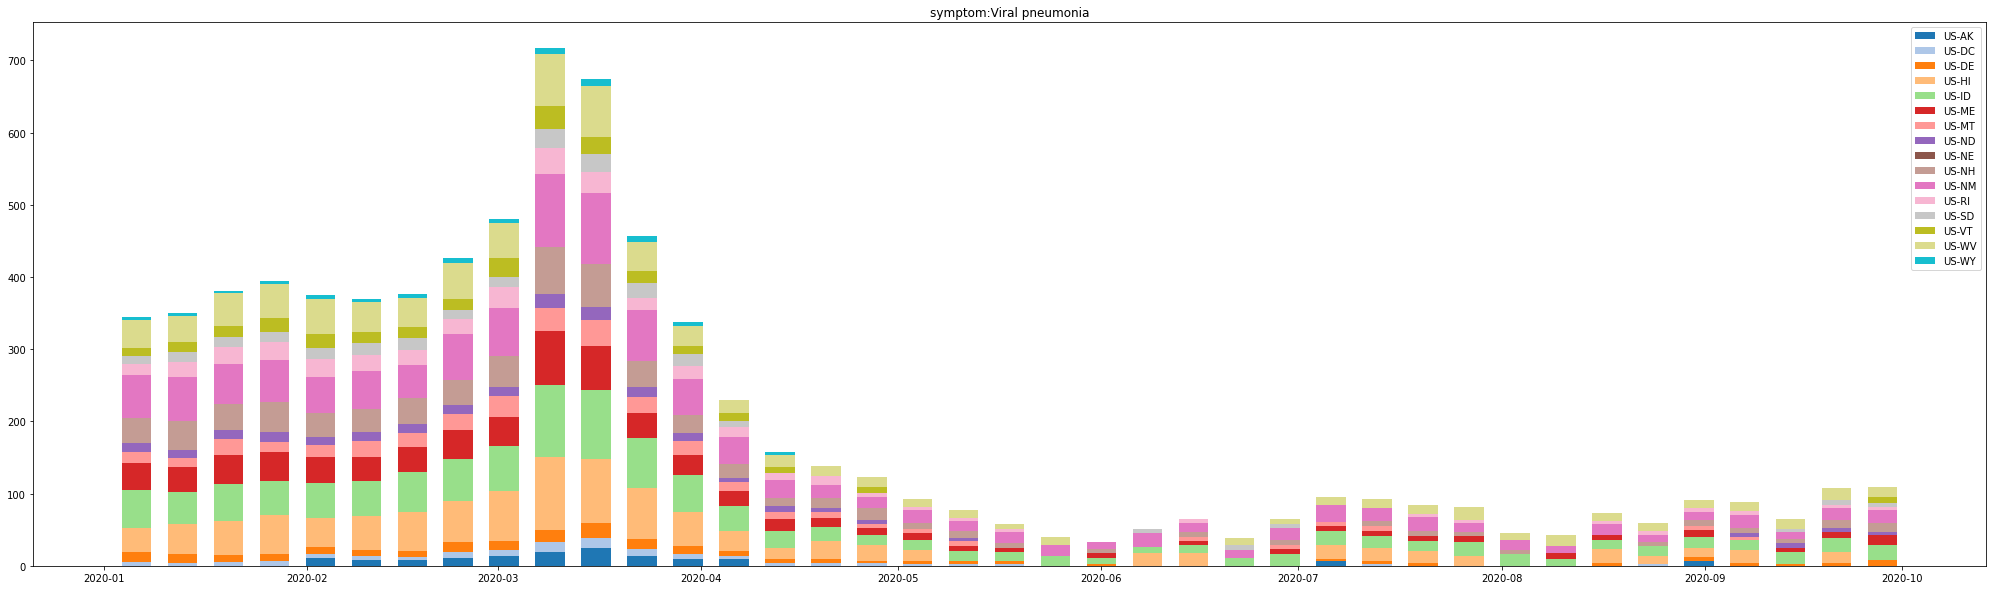

In [ ]:
## extract all symptoms
symptoms = []
for column in mergedData.columns:
    type(column)
    if 'symptom' in column:
        ## column = column[8:]
        symptoms.append(column)

del column

## iteratively plot each symptoms
weeks = mergedData['date'].unique()
regions = mergedData['open_covid_region_code'].unique()
grouped_data_by_week = mergedData.groupby('date')
grouped_by_region = mergedData.groupby('open_covid_region_code')

## for each symptom, draw a graph
for symptom in symptoms:
    fig, ax = plt.subplots(figsize=(35, 10))
    NUM_COLORS = len(regions)
    color_map = plt.get_cmap('tab20')
    ax.set_prop_cycle('color', [color_map(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    width = 4.5
    ## for each region, fetch data from each week
    previous_region_week_data = [0] * len(weeks) ## the bottom for the next region rect
    for region in regions:
        region_data_all_weeks = grouped_by_region.get_group(region)[symptom].fillna(0)
        ax.set_title(symptom)
        ax.bar(weeks, region_data_all_weeks, width, previous_region_week_data, label = region)
        ax.legend()
        ## update previous data
        region_data_list =region_data_all_weeks.to_list()
        for i in range(0, len(region_data_all_weeks)):
            previous_region_week_data[i] += region_data_list[i]

del symptoms
del weeks
del regions
del grouped_data_by_week

### PRINCIPAL COMPONENT ANALYSIS (PCA)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_impute(data, strat):

    #** This function label encodes feature 'date', one-hot-encodes the other categorical features present in 'data' and then replaces the 
    #   missing values with the 'strat'.
    #
    #   Arguments: data = data input
    #                strat = imputation strategy (i.e mean, median, etc)
    #      
    #   Returns:  new_data = resulting data output
    #              enc = fitted one_hot_encoder
    #              imp = fitted imputer

    # Label encode the date feature
    labelencoder = LabelEncoder()
    data['date'] = labelencoder.fit_transform(data['date'])  

    # OneHotEncoding
    encoder = OneHotEncoder(sparse = False)
    features_to_be_encoded = data.select_dtypes(exclude = ['float64','int'])
    encoder.fit(features_to_be_encoded)
    encoded_features = encoder.transform(features_to_be_encoded)
    encoded_data = pd.DataFrame(encoded_features).join(data.select_dtypes(include = ['float64','int']))
    
    #Imputation
    imp = SimpleImputer(missing_values=np.nan, strategy= strat)
    imp.fit(encoded_data)
    new_data= imp.transform(encoded_data)


    return new_data, encoder, imp


In [ ]:
mergedData

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,...,symptom:Rectal pain,symptom:Rumination,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,index,region_name,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-01-06,NaN,NaN,NaN,8.33,...,NaN,13.68,NaN,10.31,NaN,9.91,NaN,NaN,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,2020-01-13,NaN,NaN,NaN,8.22,...,8.41,NaN,NaN,15.49,7.65,8.41,NaN,NaN,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,2020-01-20,NaN,NaN,NaN,8.28,...,7.91,13.98,NaN,14.90,7.54,16.19,NaN,NaN,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,2020-01-27,7.47,7.65,NaN,10.39,...,9.66,10.20,NaN,15.12,NaN,NaN,NaN,NaN,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,2020-02-03,8.06,12.56,7.50,10.31,...,NaN,10.50,NaN,11.43,NaN,10.68,10.50,NaN,NaN,NaN
5,US-AK,US,United States,Alaska,US-AK,2020-02-10,NaN,10.88,NaN,11.43,...,13.60,8.89,7.62,12.88,7.44,NaN,7.80,NaN,NaN,NaN
6,US-AK,US,United States,Alaska,US-AK,2020-02-17,NaN,9.16,NaN,9.16,...,8.14,7.29,NaN,12.72,NaN,8.65,8.48,NaN,NaN,NaN
7,US-AK,US,United States,Alaska,US-AK,2020-02-24,10.61,7.29,NaN,8.95,...,10.61,9.94,NaN,9.28,7.13,8.62,11.10,NaN,NaN,NaN
8,US-AK,US,United States,Alaska,US-AK,2020-03-02,NaN,NaN,6.64,NaN,...,8.14,6.98,NaN,12.46,NaN,10.46,14.12,96494.0,Alaska,0.0
9,US-AK,US,United States,Alaska,US-AK,2020-03-09,NaN,7.91,NaN,NaN,...,7.07,8.58,8.08,13.97,NaN,NaN,18.85,96497.0,Alaska,0.0


Text(0, 0.5, 'second principal direction')

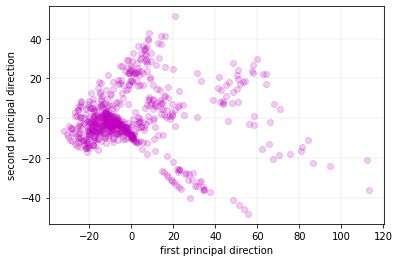

In [ ]:
# PCA using scikit-learn

pca = PCA(n_components=2)

searchTrendDataPCA, enc, imp = encode_impute(searchTrendData, 'median')  #one-hot-encoding and mean imputation
searchTrendDataPCA = pca.fit_transform(searchTrendDataPCA)

plt.scatter(searchTrendDataPCA[:,0], searchTrendDataPCA[:,1], alpha=0.2, c = 'm' )
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.xlabel("first principal direction")
plt.ylabel("second principal direction")

#print(pca.explained_variance_ratio_)

### K - Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def k_means(data, max_clusters):

    #  *** computes the inertia and silouette score for varying number of clusters and plots them to
    #  show the relationship.
    #   Returns the lists of inertia scores and silhouette scores

    inertia_values = []
    sil_scores = []

    for val in range(1, max_clusters):
        kmeans = KMeans(n_clusters = val, n_init = 30, init = 'k-means++')
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
        if val >= 2:
            sil_scores.append(silhouette_score(data, kmeans.labels_))

    plt.plot(range(1,max_clusters), inertia_values)
    plt.title('Selecting the optimal value of k using the elbow method')
    plt.xlabel('number of clusters')
    plt.ylabel('total sum of square differences')
    plt.show()

    plt.figure()
    plt.plot(range(2, max_clusters ), sil_scores)
    plt.title('Selecting the optimal value of k using the silhouette method')
    plt.xlabel('number of clusters')
    plt.ylabel('silhouette scores')
    plt.show()

    return inertia_values, sil_scores

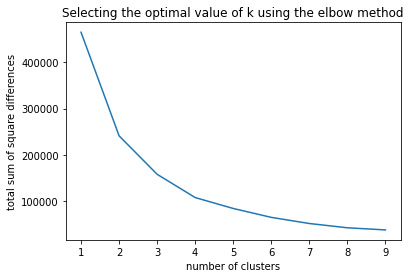

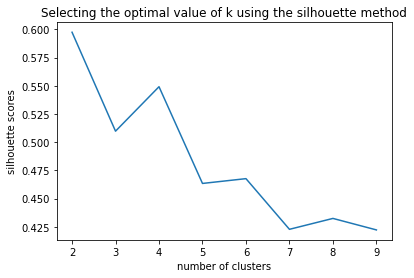

In [ ]:
# Choosing the number of clusters for PCA-reduced searchtrendData, aka searchTrendDataPCA
inertia, silhouet = k_means(searchTrendDataPCA, 10)

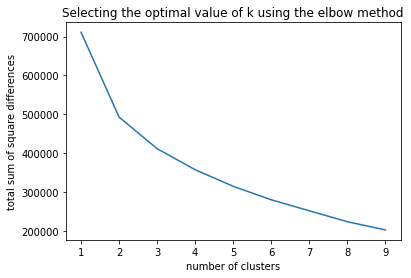

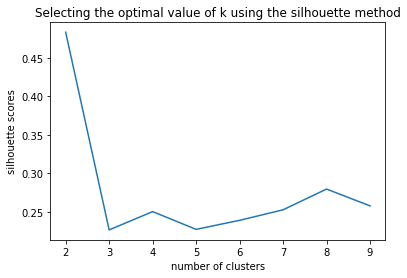

In [ ]:
# Choosing the number of clusters for searchtrendData
searchTrendDataEncoded, enc, imp = encode_impute(searchTrendData, 'mean')
inertia_raw, silhouette_raw = k_means(searchTrendDataEncoded, 10 )

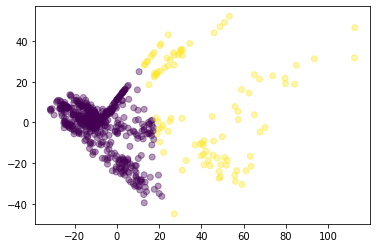

In [ ]:
# choose 2 based on the silhouette and the elbow method
kmeans = KMeans(n_clusters = 2, n_init = 30, init = 'k-means++')
prediction = kmeans.fit_predict(searchTrendDataPCA)
plt.scatter(searchTrendDataPCA[:,0], searchTrendDataPCA[:,1], c=prediction, alpha=0.4)

# Task 3: Supervised Learning

## 1. Splitting the data into train and validation based on time or based on regions

In [ ]:
## a function that splits the dataset into 80% training set and 20% validation set
def split_dataset_on(dataset, on):
    gss = GroupShuffleSplit(n_splits = 2, train_size = 0.8)
    training, validation = next(gss.split(dataset, groups = dataset[on]))
    training_set = dataset.iloc[training]
    validation_set = dataset.iloc[validation]
    return training_set, validation_set

training_set_region, validation_set_region = split_dataset_on(mergedData, 'open_covid_region_code')
training_set_time, validation_set_time = split_dataset_on(mergedData, 'date')

## 2. Regression performance comparison between KNNs and Decision Trees

DECISION TREES

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# I don't think we need the 'index' and 'region_name' columns from the hospitalization dataset in the mergedData
# LFY: Feel free to drop them if you want
data = mergedData.drop(['index', 'region_name'], axis=1)

## since hospitalized_new is our target, we take regions with valid entries in hospitalized_new.
data = data[data['hospitalized_new'].notna()]



Text(0, 0.5, 'mean_squared_error')

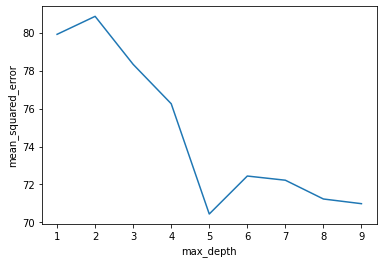

In [ ]:
# FINDING THE OPTIMUM MAX_DEPTH

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt


X, enc, imp = one_hot_encode(data.loc[:, data.columns != 'hospitalized_new'])
#print('encoded shape', data_new.shape)

y = data['hospitalized_new']

train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=113)


results_ = []
for d in range(1,10):
    
    tree = DecisionTreeRegressor(max_depth=d)
    model = tree.fit(train_x, train_y)
    

    # ****** ASSESSING PERFORMANCE ********
    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))

    results_.append(error)

plt.plot(range(1,10), results_)
plt.xlabel('max_depth')
plt.ylabel('mean_squared_error')


REGION BASED SPLIT WITH 5-FOLD CROSS-VALIDATION

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'mean_squared_error')

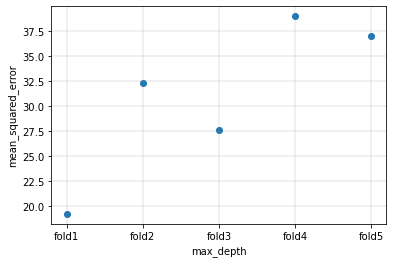

In [ ]:
from sklearn.model_selection import GroupKFold

X, enc, imp = encode_impute(data.loc[:, data.columns != 'hospitalized_new'], 'mean')
y = data['hospitalized_new']
groups = data['open_covid_region_code']

gkf = GroupKFold(n_splits=5)
results_ = []

for train_index, test_index in gkf.split(X, y, groups=groups):
    train_x, valid_x, train_y, valid_y = X[train_index], X[valid_index], y.iloc[train_index], y.iloc[valid_index]

    tree = DecisionTreeRegressor(max_depth=4)
    model = tree.fit(train_x, train_y)

    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))

    results_.append(error)

folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
plt.scatter(folds, results_)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.9)
plt.xlabel('max_depth')
plt.ylabel('mean_squared_error')


TIME BASED SPLIT

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'mean_squared_error')

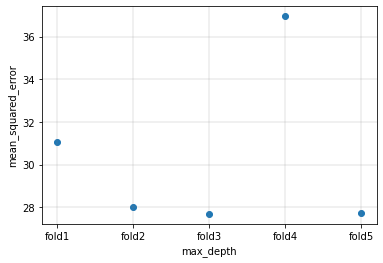

In [ ]:
from sklearn.model_selection import GroupKFold

X, enc, imp = encode_impute(data.loc[:, data.columns != 'hospitalized_new'], 'mean')
y = data['hospitalized_new']
groups = data['date']

gkf = GroupKFold(n_splits=5)
results_ = []

for train_index, test_index in gkf.split(X, y, groups=groups):
    train_x, valid_x, train_y, valid_y = X[train_index], X[valid_index], y.iloc[train_index], y.iloc[valid_index]

    tree = DecisionTreeRegressor(max_depth=4)
    model = tree.fit(train_x, train_y)

    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))

    results_.append(error)

folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
plt.scatter(folds, results_)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.9)
plt.xlabel('max_depth')
plt.ylabel('mean_squared_error')

#### KNN

RMSE value for k =  1 is: 49.837697744828205
RMSE value for k =  2 is: 63.091434650145594
RMSE value for k =  3 is: 53.02869101908335
RMSE value for k =  4 is: 48.10417371836059
RMSE value for k =  5 is: 47.68929781631926
RMSE value for k =  6 is: 49.580679676616505
RMSE value for k =  7 is: 47.129178867167646
RMSE value for k =  8 is: 45.58377742753563
RMSE value for k =  9 is: 49.33235418914226
RMSE value for k =  10 is: 48.337190449823666
RMSE value for k =  11 is: 48.13841072884519
RMSE value for k =  12 is: 46.678363363090845
RMSE value for k =  13 is: 45.81232681514206
RMSE value for k =  14 is: 45.4969532616496
RMSE value for k =  15 is: 44.69049308969173
RMSE value for k =  16 is: 44.485555140983195
RMSE value for k =  17 is: 44.40913074968881
RMSE value for k =  18 is: 44.670374375839096
RMSE value for k =  19 is: 44.363650379281495
RMSE value for k =  20 is: 44.65311201496889
RMSE value for k =  21 is: 44.43125583108518
RMSE value for k =  22 is: 44.408739488790154
RMSE value

Text(0, 0.5, 'mean_squared_error')

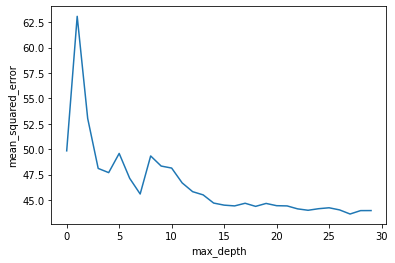

In [ ]:
# FINDING THE OPTIMAL K


from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

X, enc, imp = one_hot_encode(data.loc[:, data.columns != 'hospitalized_new'])
#print('encoded shape', data_new.shape)

y = data['hospitalized_new']

train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=193)

rmse_val = []

for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(train_x, train_y)
    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))
    rmse_val.append(error)
    print('RMSE value for k = ',K,'is:',error)


plt.plot(range(30), rmse_val)
plt.xlabel('max_depth')
plt.ylabel('mean_squared_error')

KNN - REGION BASED CROSS-VALIDATION using optimal k from above

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'mean_squared_error')

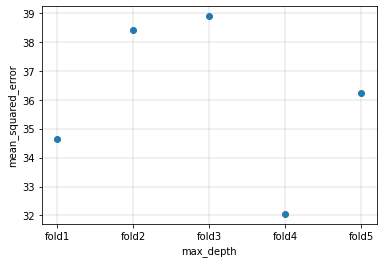

In [ ]:
from sklearn.model_selection import GroupKFold

X, enc, imp = encode_impute(data.loc[:, data.columns != 'hospitalized_new'], 'mean')
y = data['hospitalized_new']
groups = data['open_covid_region_code']

gkf = GroupKFold(n_splits=5)
results_ = []

for train_index, test_index in gkf.split(X, y, groups=groups):
    train_x, valid_x, train_y, valid_y = X[train_index], X[valid_index], y.iloc[train_index], y.iloc[valid_index]

    model = neighbors.KNeighborsRegressor(n_neighbors = 15)
    model.fit(train_x, train_y)
    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))
    results_.append(error)
    


folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
plt.scatter(folds, results_)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.9)
plt.xlabel('max_depth')
plt.ylabel('mean_squared_error')

KNN, DATE BASED CROSS-VALIDATION

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'mean_squared_error')

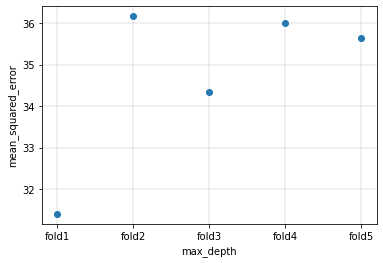

In [ ]:
from sklearn.model_selection import GroupKFold

X, enc, imp = encode_impute(data.loc[:, data.columns != 'hospitalized_new'], 'mean')
y = data['hospitalized_new']
groups = data['date']

gkf = GroupKFold(n_splits=5)
results_ = []

for train_index, test_index in gkf.split(X, y, groups=groups):
    train_x, valid_x, train_y, valid_y = X[train_index], X[valid_index], y.iloc[train_index], y.iloc[valid_index]

    model = neighbors.KNeighborsRegressor(n_neighbors = 15)
    model.fit(train_x, train_y)
    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))
    results_.append(error)
    


folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
plt.scatter(folds, results_)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.9)
plt.xlabel('max_depth')
plt.ylabel('mean_squared_error')

RMSE value for k =  1 is: 89.04442200895625
RMSE value for k =  2 is: 76.2283501306198
RMSE value for k =  3 is: 68.35513325584438
RMSE value for k =  4 is: 63.81300362636272
RMSE value for k =  5 is: 64.88679652777107
RMSE value for k =  6 is: 63.82675612922685
RMSE value for k =  7 is: 59.31680455327878
RMSE value for k =  8 is: 57.177504715181
RMSE value for k =  9 is: 55.18071525069245
RMSE value for k =  10 is: 52.42464722211906
RMSE value for k =  11 is: 52.7008732714768
RMSE value for k =  12 is: 51.87270440338746
RMSE value for k =  13 is: 55.152834255476385
RMSE value for k =  14 is: 53.217434318077444
RMSE value for k =  15 is: 54.682331458501054
RMSE value for k =  16 is: 54.93363926603956
RMSE value for k =  17 is: 55.68149379443422
RMSE value for k =  18 is: 57.62251014703666
RMSE value for k =  19 is: 57.192432312106355
RMSE value for k =  20 is: 60.014632685401295


Text(0, 0.5, 'RMSE')

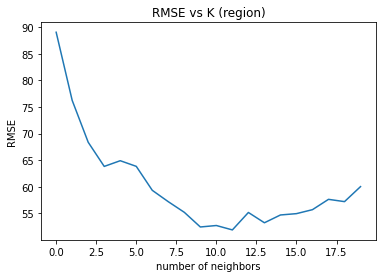

In [ ]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt

training_set_region_clean   = training_set_region.dropna()
validation_set_region_clean = validation_set_region.dropna()

training_set_region_clean   =   training_set_region_clean.drop(['open_covid_region_code','date','index','country_region_code','country_region','sub_region_1','sub_region_1_code','region_name'], axis=1)
validation_set_region_clean = validation_set_region_clean.drop(['open_covid_region_code','date','index','country_region_code','country_region','sub_region_1','sub_region_1_code','region_name'], axis=1)

X = list(training_set_region_clean.columns)
X.remove('hospitalized_new')
y = ['hospitalized_new']
rmse_val = []

for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(training_set_region_clean[X], training_set_region_clean[y])
    result = model.predict(validation_set_region_clean[X])
    error = sqrt(mean_squared_error(validation_set_region_clean[y],result))
    rmse_val.append(error)
    print('RMSE value for k = ',K,'is:',error)

curve = pd.DataFrame(rmse_val)
plt = curve.plot(title = 'RMSE vs K (region)',legend=False)
plt.set_xlabel('number of neighbors')
plt.set_ylabel('RMSE')

##### KNN - time

RMSE value for k =  1 is: 122.76865584155777
RMSE value for k =  2 is: 99.81005770486068
RMSE value for k =  3 is: 114.80835192597128
RMSE value for k =  4 is: 118.31460281003034
RMSE value for k =  5 is: 111.49426634841555
RMSE value for k =  6 is: 115.12309377173948
RMSE value for k =  7 is: 112.80402607761715
RMSE value for k =  8 is: 115.0605301362639
RMSE value for k =  9 is: 116.2328619165011
RMSE value for k =  10 is: 117.95763767435444
RMSE value for k =  11 is: 119.09473408483477
RMSE value for k =  12 is: 120.74225768555635
RMSE value for k =  13 is: 122.49879902344566
RMSE value for k =  14 is: 123.63874144774884
RMSE value for k =  15 is: 124.65774095880441
RMSE value for k =  16 is: 125.52351533392344
RMSE value for k =  17 is: 126.83076586620953
RMSE value for k =  18 is: 126.55602821471535
RMSE value for k =  19 is: 127.42663337603197
RMSE value for k =  20 is: 128.70373879943187


Text(0, 0.5, 'RMSE')

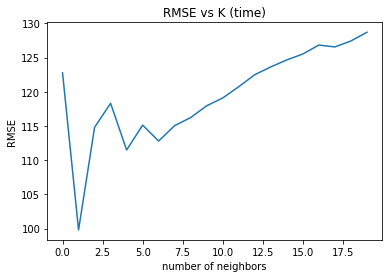

In [ ]:
training_set_time_clean   = training_set_time.dropna()
validation_set_time_clean = validation_set_time.dropna()

training_set_time_clean   =   training_set_time_clean.drop(['open_covid_region_code','date','index','country_region_code','country_region','sub_region_1','sub_region_1_code','region_name'], axis=1)
validation_set_time_clean = validation_set_time_clean.drop(['open_covid_region_code','date','index','country_region_code','country_region','sub_region_1','sub_region_1_code','region_name'], axis=1)

X = list(training_set_time_clean.columns)
X.remove('hospitalized_new')
y = ['hospitalized_new']
rmse_val = []

for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(training_set_time_clean[X], training_set_time_clean[y])
    result = model.predict(validation_set_time_clean[X])
    error = sqrt(mean_squared_error(validation_set_time_clean[y],result))
    rmse_val.append(error)
    print('RMSE value for k = ',K,'is:',error)

curve = pd.DataFrame(rmse_val)
plt = curve.plot(title = 'RMSE vs K (time)',legend=False)
plt.set_xlabel('number of neighbors')
plt.set_ylabel('RMSE')